In [1]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:

# 设置设备（GPU如果可用，否则CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
class DQN(nn.Module):
    
    def __init__(self,state_size,action_size):
        super(DQN,self).__init__()
        self.fc1 = nn.Linear(state_size,24)
        self.fc2 = nn.Linear(24,24)
        self.fc3 = nn.Linear(24,action_size)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
class DQNAgent:
    
    def __init__(self,state_size,action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        
        self.model = DQN(state_size,action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(),lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def remember(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
    
    
    def act(self,state,explore=True):
        if explore and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        state = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values).item()
    
    def replay(self,batch_size):
        minibatch = random.sample(self.memory,batch_size)
        
        for state,action,reward,next_state,done in minibatch:
            state = torch.FloatTensor(state).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            
            target = reward
            if not done:
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.model(next_state)).item()
            
            current_q = self.model(state)
            target_f = current_q.clone().detach()
            target_f[0][action] = target
            
            self.optimizer.zero_grad()
            loss = self.criterion(current_q,target_f)
            loss.backward()
            self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self,name):
        self.model.load_state_dict(torch.load(name))
    
    def save(self,name):
        torch.save(self.model.state_dict(),name)
            

            

In [6]:
def preprocess_state(state,state_size):
    state_one_hot = np.zeros(state_size)
    state_one_hot[state] = 1
    return np.reshape(state_one_hot,[1,state_size])

In [7]:
def train_dqn(episodes,render=False):
    env = gym.make('CliffWalking-v0')
    state_size = env.observation_space.n
    action_size = env.action_space.n
    agent = DQNAgent(state_size,action_size)
    batch_size = 32
    rewards_history = []
    
    for e in range(episodes):
        state,_ = env.reset()
        state = preprocess_state(state,state_size)
        total_reward = 0
        
        for time in range(500):
            if render:
                env.render()
            
            action = agent.act(state)
            next_state,reward,done,_,_ = env.step(action)
            next_state = preprocess_state(next_state,state_size)
            
            agent.remember(state,action,reward,next_state,done)
            
            state = next_state
            total_reward += reward
            
            if done:
                print(f"episode: {e+1}/{episodes}, score: {total_reward}, epsilon: {agent.epsilon:.2f}")
                break
            
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        
        rewards_history.append(total_reward)
        
        if (e+1) % 10 == 0:
            print(e,rewards_history[-1])
            agent.save(f'cliff{e}.pt')
    return agent, rewards_history

In [8]:
def test_agent(agent, episodes=10, render=True):
    env = gym.make('CliffWalking-v0', render_mode='human' if render else None)
    state_size = env.observation_space.n
    
    for e in range(episodes):
        state, _ = env.reset()
        state = preprocess_state(state, state_size)
        total_reward = 0
        done = False
        
        while not done:
            if render:
                env.render()
            
            action = agent.act(state, explore=False)  # 测试时不探索
            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_state(next_state, state_size)
            
            state = next_state
            total_reward += reward
            
            if done:
                print(f"Test episode: {e+1}/{episodes}, score: {total_reward}")
                break

In [9]:
def plot_rewards(rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title('DQN Training on CliffWalking-v0')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('cliff_walking_dqn_rewards.png')
    plt.show()

9 -500
19 -500
29 -500
39 -500
49 -500
59 -500
69 -500
79 -698
89 -698
99 -500
109 -698
119 -599
129 -500
139 -500
149 -500
159 -500
169 -599
episode: 174/500, score: -190, epsilon: 0.01
episode: 177/500, score: -235, epsilon: 0.01
episode: 178/500, score: -201, epsilon: 0.01
episode: 179/500, score: -76, epsilon: 0.01
episode: 180/500, score: -43, epsilon: 0.01
179 -43
episode: 181/500, score: -144, epsilon: 0.01
episode: 182/500, score: -23, epsilon: 0.01
episode: 183/500, score: -21, epsilon: 0.01
episode: 184/500, score: -17, epsilon: 0.01
episode: 185/500, score: -15, epsilon: 0.01
episode: 186/500, score: -16, epsilon: 0.01
episode: 187/500, score: -18, epsilon: 0.01
episode: 188/500, score: -42, epsilon: 0.01
episode: 189/500, score: -19, epsilon: 0.01
episode: 190/500, score: -15, epsilon: 0.01
189 -15
episode: 191/500, score: -15, epsilon: 0.01
episode: 192/500, score: -15, epsilon: 0.01
episode: 193/500, score: -19, epsilon: 0.01
episode: 194/500, score: -33, epsilon: 0.01
ep

episode: 356/500, score: -14, epsilon: 0.01
episode: 357/500, score: -15, epsilon: 0.01
episode: 358/500, score: -15, epsilon: 0.01
episode: 359/500, score: -119, epsilon: 0.01
episode: 360/500, score: -13, epsilon: 0.01
359 -13
episode: 361/500, score: -18, epsilon: 0.01
episode: 362/500, score: -14, epsilon: 0.01
episode: 363/500, score: -19, epsilon: 0.01
episode: 364/500, score: -13, epsilon: 0.01
episode: 365/500, score: -16, epsilon: 0.01
episode: 366/500, score: -15, epsilon: 0.01
episode: 367/500, score: -17, epsilon: 0.01
episode: 368/500, score: -15, epsilon: 0.01
episode: 369/500, score: -15, epsilon: 0.01
episode: 370/500, score: -16, epsilon: 0.01
369 -16
episode: 371/500, score: -18, epsilon: 0.01
episode: 372/500, score: -13, epsilon: 0.01
episode: 373/500, score: -15, epsilon: 0.01
episode: 374/500, score: -15, epsilon: 0.01
episode: 375/500, score: -13, epsilon: 0.01
episode: 376/500, score: -17, epsilon: 0.01
episode: 377/500, score: -15, epsilon: 0.01
episode: 378/50

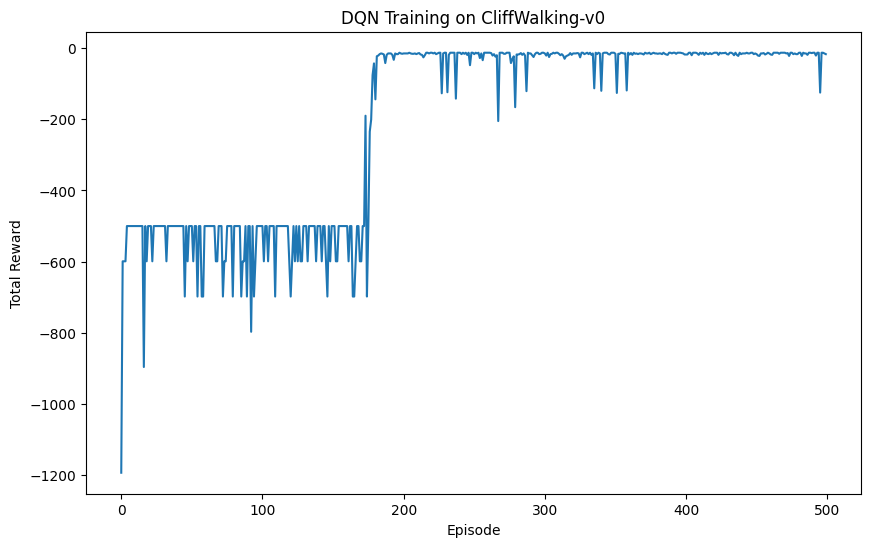

2025-05-21 14:35:36.315 python[3444:17719959] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-21 14:35:36.315 python[3444:17719959] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Test episode: 1/5, score: -13
Test episode: 2/5, score: -13
Test episode: 3/5, score: -13
Test episode: 4/5, score: -13
Test episode: 5/5, score: -13


In [10]:
if __name__ == "__main__":
    # 训练智能体
    trained_agent, rewards = train_dqn(episodes=500)
    
    # 绘制奖励历史
    plot_rewards(rewards)
    
    # 保存最终模型
    trained_agent.save("cliff_walking_dqn_final.pt")
    
    # 测试训练好的智能体
    test_agent(trained_agent, episodes=5) 